In [1]:
import codecs
import os
import csv as csv
import nltk as nltk
import re
from nltk.corpus import wordnet as wn
import pandas as pd
import nltk
import matplotlib.pyplot as plt

from nltk.tag import map_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer


# Analyse des opinions par règles sur desdonnées de twitter

**Vincent Martinez**

## Prétraitements du corpus

In [2]:
dicoSlangFile = "SlangLookupTable.txt"
csvTweetData = "testdata.manual.2009.06.14.csv"
boosterFile = "BoosterWordList.txt"
emotesFile = "EmoticonLookupTable.txt"
negativesFile = "NegatingWordList.txt"
sentiwordnet = "SentiWordNet_3.0.0_20130122.txt"

In [3]:
# Lecture d'un fichier dictionnaire
def read_dict(filename):
    file = codecs.open(filename, 'r', encoding="utf-8", errors='ignore')
    data = {}
    for r in file:
        d = r.split("\t")
        data[d[0]] = d[1].strip()    
    return data

In [4]:
# Lecture d'un fichier simple
def read(filename):
    file = codecs.open(filename, 'r', encoding="utf-8", errors='ignore')
    data = set()
    for r in file:        
        data.add(r.strip())        
    return data

In [5]:
# Lecture des données

slang = read_dict(dicoSlangFile)
emotes = read_dict(emotesFile)
negatives = read(negativesFile)
booster = read_dict(boosterFile)




In [6]:
# Reading tweet database
tweets = pd.read_csv(csvTweetData, delimiter=',', names=["sentiment","id","date","lyx","user", "tweet"])

In [7]:
def parse_tweet(tweet, slang, emotes):
    """
    Parse a tweet, spliting the words
    """
    words = []
    emote = []
    hashtags = 0
    tweet = tweet.replace("#", " #").replace("@", " @").replace("&amp;"," & ") # replace some chars
    for w in tweet.split():                       
            if w[0]=="#":
                #print(w)
                hashtags +=1 # count also ## as 2 hashtags
            else:
                # ref, http, &amp;
                if not (w[0] == "@" or 'http' in w):
                    words.append(w)
                    
                    # Est ce que le mot contient un ou des emotes?
                    for em in emotes:
                        # Est-ce un emote?
                        if em in w:
                            emote.append(em)
    
    # On utilise le word tokenizer de nltk pour etre performant apres le pré-prcessiong
    tokens = nltk.word_tokenize(' '.join(words))
    words=[]
    for t in tokens:
        if t in slang:
            # On remplace le slang
            words.append(slang[t])
        else:
             words.append(t)
    
    return words,emote,hashtags
                

In [8]:
tweet_parsed = []
emote_tweet_parsed = []
hashtags = 0

# On boucle sur tous les tweets
# on recupere les tweet_parsed et les emotes
for tw in tweets.tweet:
    parsed,emote_parsed, tags = parse_tweet(tw, slang, emotes)
    tweet_parsed.append(parsed)
    emote_tweet_parsed.append(emote_parsed)
    hashtags+=tags
    
print(f"Le nombre de hashtag contenu dans le corpus est de {hashtags} en comptant '##' comme 2 hashtags!")

Le nombre de hashtag contenu dans le corpus est de 52 en comptant '##' comme 2 hashtags!


## Etiquetage grammatical

In [9]:
tweet_tags = []
verb = 0
for tw in tweet_parsed:
    twg = nltk.pos_tag(tw,tagset='universal')
    tweet_tags.append(twg)
    for t  in twg:
        if t[1]=="VERB":
            verb+=1
            




In [10]:
print(f'Nombre de verbes dans le corpus: {verb}')

Nombre de verbes dans le corpus: 1154


## Algorithme de détection : utilisation du dictionnaire Sentiwordnet

In [11]:
def filter_tweet(tweet_tag):    
    return filter(lambda twg : (twg[1]=='VERB') or(twg[1]=='ADJ') or (twg[1]=='NOUN') or (twg[1]=='ADV'), tweet_tag)
    

In [12]:
from nltk.corpus.reader import sentiwordnet as swn
dicoSentiWordnetFile ='SentiWordNet_3.0.0_20130122.txt'
swn_dict = swn.SentiWordNetCorpusReader('', [dicoSentiWordnetFile])

In [13]:
def compute_scores(tweet_tags, tweet_emotes=None, use_boost_neg=False, use_emotes=False):
    morphy_tag = {'NOUN':'n', 'ADJ':'a', 'VERB':'v', 'ADV':'r'}
    tonality = []
    word_repartition = []
    for index,twg in enumerate(tweet_tags):
        twg = filter_tweet(twg)
        score = 0
        words = {}
        words["positive"] = 0
        words["negative"] = 0
        score_pos = 0
        score_neg = 0
        prev_neg = False
        prev_booster = False
        for tw in twg:                        
            senti = list(swn_dict.senti_synsets(tw[0],morphy_tag[tw[1]]))
            if len(senti) >0:            
                pos = senti[0].pos_score()
                neg = senti[0].neg_score()
                
                if pos > neg:
                    words["positive"] +=1
                elif pos < neg:
                    words["negative"] +=1

                if use_boost_neg :
                    if prev_booster : 
                        pos *=2
                        neg *=2
                    if prev_neg:
                        tmp = pos
                        pos = neg
                        neg = tmp
                prev_neg = False
                prev_booster = False
                score_pos +=pos
                score_neg +=neg

            if tw[0] in negatives:
                    prev_neg = True

            if tw[0] in booster:
                    prev_booster = True
        score = score_pos - score_neg
        word_repartition.append(words)
        
        if use_emotes :
            for emote in tweet_emotes[index]:
                score +=int(emotes[emote])
        
        if score >0:
            score = 4
        elif score <0:
            score = 0
        else:
            score = 2        
        tonality.append(score)
    return tonality, word_repartition

In [14]:
tonality, words = compute_scores(tweet_tags)

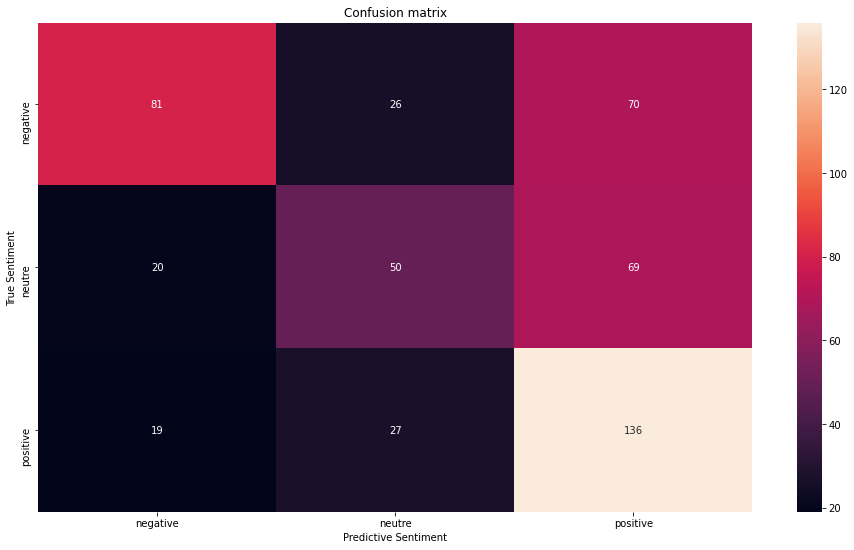

In [15]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(tweets["sentiment"], tonality)
plt.figure(figsize=(16,9))
ax = sn.heatmap(matrix, annot=True,xticklabels=['negative','neutre','positive'], yticklabels=['negative','neutre','positive'],fmt='.0f') 
ax.set(title="Confusion matrix",
      xlabel="Predictive Sentiment",
      ylabel="True Sentiment",)
plt.show() 

La matrice de confusion permet donc de voir les prédictions par rapport aux réels sentiment. On note par exemple, le score assez mauvais des prédictions 'positive'. 136 tweets sont bien prédits alors que 72 tweet sont taggués positifs alors qu'ils sont négative et 69 prédit positif alors qu'ils sont neutre.

## Algorithme de détection : gestion de la négation et des modifieurs

In [16]:
# Add some negative words
negatives.add("n't")
negatives.add("'t")


In [17]:
tonality, words = compute_scores(tweet_tags, None, True)

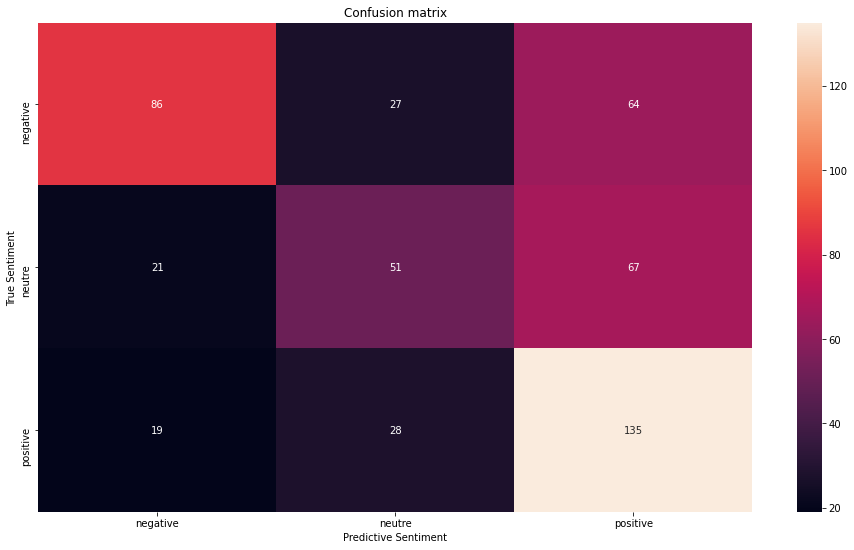

In [18]:
matrix = confusion_matrix(tweets["sentiment"], tonality)
plt.figure(figsize=(16,9))
ax = sn.heatmap(matrix, annot=True,xticklabels=['negative','neutre','positive'], yticklabels=['negative','neutre','positive'],fmt='.0f') 
ax.set(title="Confusion matrix",
      xlabel="Predictive Sentiment",
      ylabel="True Sentiment",)
plt.show() 

In [19]:
tweets["negative"] = [ w["negative"] for w in words]

In [20]:
sum_neg_in_pos = tweets[tweets.sentiment==4]["negative"].sum()

print(f"Il y a {sum_neg_in_pos} mots négatifs dans les tweets positifs")

Il y a 99 mots négatifs dans les tweets positifs


L'intégration des mutilplicateur et des négations n'a pas beaucoup améliorer les scores. pire, le score de  positif a meme diminué.

## Algorithme de détection : gestion des émoticones

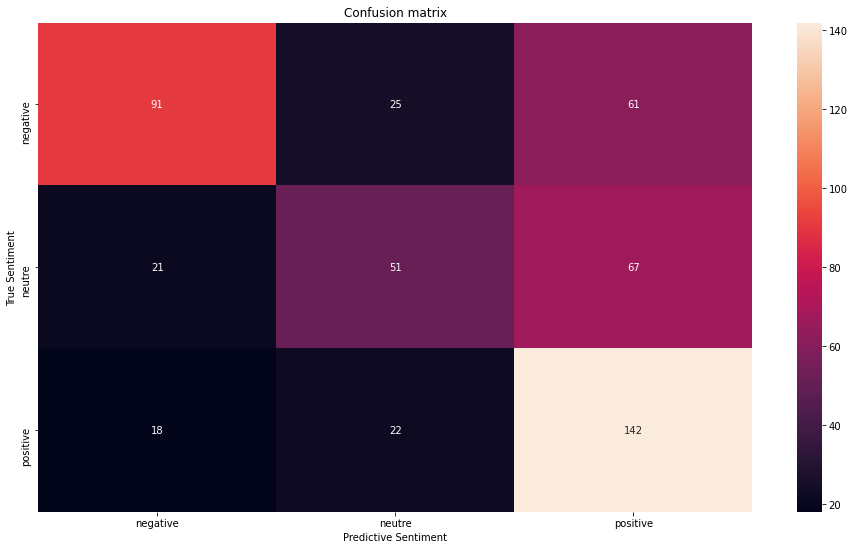

In [21]:
tonality, negative = compute_scores(tweet_tags, emote_tweet_parsed, True, True)
matrix = confusion_matrix(tweets["sentiment"], tonality)
plt.figure(figsize=(16,9))
ax = sn.heatmap(matrix, annot=True,xticklabels=['negative','neutre','positive'], yticklabels=['negative','neutre','positive'],fmt='.0f') 
ax.set(title="Confusion matrix",
      xlabel="Predictive Sentiment",
      ylabel="True Sentiment",)
plt.show()

In [22]:
print(f"Le nombre d'emotes contenu dans le corpus est de {sum([len(emotes) for emotes in emote_tweet_parsed])}")

Le nombre d'emotes contenu dans le corpus est de 54


## Algorithme de détection : votre version vs Vader

In [23]:
sia = SentimentIntensityAnalyzer()

vader = []
for t in tweets.tweet:
    score = sia.polarity_scores(t)['compound'] 
    if score >0:
        vader.append(4)
    elif score <-0:
        vader.append(0)
    else:
        vader.append(2)

[Text(123.0, 0.5, 'True Sentiment'),
 Text(0.5, 60.0, 'Predictive Sentiment'),
 Text(0.5, 1.0, 'Confusion matrix for Vader')]

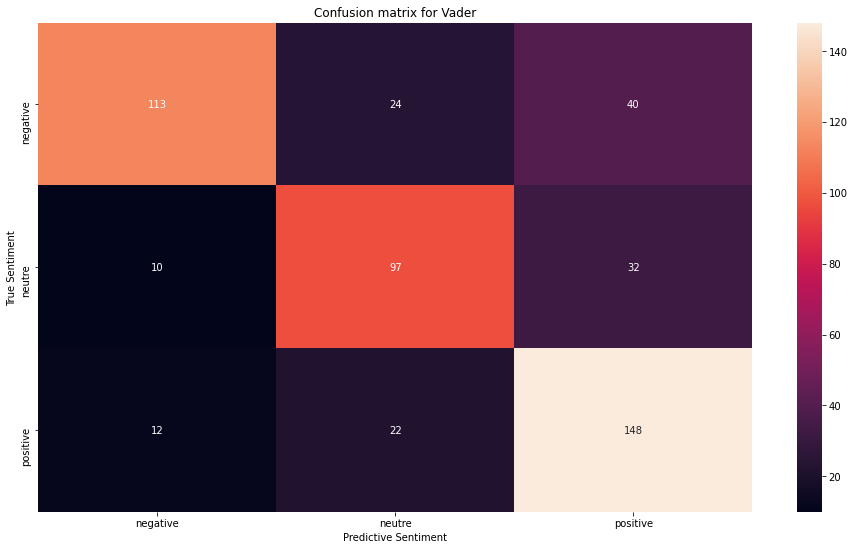

In [24]:
matrix = confusion_matrix(tweets["sentiment"], vader)
plt.figure(figsize=(16,9))
ax = sn.heatmap(matrix, annot=True,xticklabels=['negative','neutre','positive'], yticklabels=['negative','neutre','positive'],fmt='.0f') 
ax.set(title="Confusion matrix for Vader",
      xlabel="Predictive Sentiment",
      ylabel="True Sentiment",)
